In [2]:
import matplotlib.pyplot as plt
from ParticleTracerLatticeClass import ParticleTracerLattice
import scipy.interpolate as spi
import sys
from ParaWell import ParaWell
from ParticleTracerClass import ParticleTracer
from ParticleClass import Swarm, Particle
import time
from SwarmTracerClass import SwarmTracer
import scipy.optimize as spo
import numpy as np

rFact=.675

PTL = ParticleTracerLattice(200.0)
PTL.add_Halbach_Lens_Sim(.01, .5)
PTL.add_Combiner_Sim('combinerV2.txt')
PTL.add_Halbach_Lens_Sim(.01, .5)
PTL.add_Halbach_Bender_Sim_Segmented_With_End_Cap(.0254, .01, None, 1.0, 1e-3, rOffsetFact=rFact)
PTL.add_Halbach_Lens_Sim(.01, None)
PTL.add_Halbach_Bender_Sim_Segmented_With_End_Cap(.0254, .01, None, 1.0, 1e-3, rOffsetFact=rFact)
PTL.end_Lattice(constrain=True,enforceClosedLattice=True,surpressWarning=True)

In [3]:
def generate_Probe_Sample(v0, seed=None, rpPoints=3, rqPoints=3):
    # value of 3 for points is a good value from testing to give qualitative results
    if type(seed) == int:
        np.random.seed(seed)
    pMax = 10.0
    numParticlesArr = np.arange(4, 4 * (rpPoints + 1), 4)
    coords = np.asarray([[0, 0]])
    for numParticles in numParticlesArr:
        r = pMax * numParticles / numParticlesArr.max()
        phiArr = np.linspace(0, 2 * np.pi, numParticles, endpoint=False)
        tempCoords = np.column_stack((r * np.cos(phiArr), r * np.sin(phiArr)))
        coords = np.row_stack((coords, tempCoords))
    pSamples = np.column_stack((-np.ones(coords.shape[0]) * v0, coords))
    # plt.scatter(pSamples[:,1],pSamples[:,2])
    # plt.show()

    # create position samples

    qMax = 2.5e-3
    numParticlesArr = np.arange(4, 4 * (rqPoints + 1), 4)
    coords = np.asarray([[0, 0]])
    for numParticles in numParticlesArr:
        r = qMax * numParticles / numParticlesArr.max()
        phiArr = np.linspace(0, np.pi, numParticles, endpoint=True)
        tempCoords = np.column_stack((r * np.cos(phiArr), r * np.sin(phiArr)))
        coords = np.row_stack((coords, tempCoords))
    qSamples = np.column_stack((-np.zeros(coords.shape[0]), coords))
    # plt.scatter(qSamples[:,1],qSamples[:,2])
    # plt.show()

    swarm = Swarm()
    for qCoord in qSamples:
        for pCoord in pSamples:
            if qCoord[2] == 0 and pCoord[2] < 0:  # exploit symmetry along z=0 for momentum by exluding downard
                # directed points
                pass
            else:
                swarm.add_Particle(qi=qCoord.copy(), pi=pCoord.copy())
    if type(seed) == int:
        np.random.seed(int(time.time()))
    # print('Number of particles generated: ', swarm.num_Particles())
    return swarm

4.630854282489147


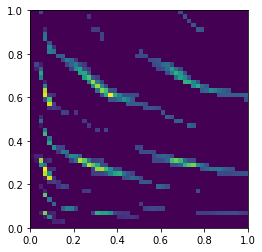

In [27]:
h = 1e-5
T = 10.0
swarmTracer = SwarmTracer(PTL)
swarm0 = generate_Probe_Sample(200.0, seed=42)
swarm0 = swarmTracer.move_Swarm_To_Combiner_Output(swarm0)
swarmTest=Swarm()
swarmTest.add_Particle()
swarmTest.add_Particle(qi=np.asarray([-1e-10,1e-3,0]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,-1e-3,0]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,0,-1e-3]))
swarmTest.add_Particle(qi=np.asarray([-1e-10,0,1e-3]))


num=50
BArr=np.linspace(0,1.0,num)
coordsArr=np.asarray(np.meshgrid(BArr,BArr)).T.reshape(-1,2)
def revFunc(X):
    # if (X[0]==0 or X[0]==1) and X[1]==1:
    #     return 0.0
    # if X[0]==1 and X[1]==0:
    #     return 10.0
    PTL.elList[2].set_BpFact(X[0])
    PTL.elList[4].set_BpFact(X[1])
    minRevs = 5.0  # test particle must achieve at least this many revolutions
    swarmTestNew=swarmTracer.trace_Swarm_Through_Lattice(swarmTest,1e-5,1.5 * minRevs * PTL.totalLength / 200.0,parallel=False)
    stable=False
    for particle in swarmTestNew:
        if particle.revolutions>minRevs:
            stable=True
    if stable==False:
        return 0.0
    else:
        swarm = swarmTracer.trace_Swarm_Through_Lattice(swarm0, 1e-5, T, parallel=False, fastMode=True)
        # print(X,swarm.survival_Rev())
        return swarm.survival_Rev()



helper=ParaWell()
results=helper.parallel_Problem(revFunc,coordsArr,onlyReturnResults=True,numWorkers=30)
results=np.asarray(results)
# print(rFact,args[np.argmax(results)],np.max(results))
image=results.reshape(num,num)
image=np.flip(np.transpose(image),axis=0)
extent=[0.0,1.0,0.0,1.0]
print(np.nanmax(image)) #5.42
plt.imshow(image,extent=extent)
plt.show()

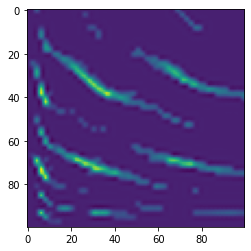

In [28]:
import scipy.interpolate as spi
func=spi.RBFInterpolator(coordsArr,results)
num=100
BArr=np.linspace(0,1.0,num)
testArr=np.asarray(np.meshgrid(BArr,BArr)).T.reshape(-1,2)
vals=func(testArr)

imageTest=vals.reshape(num,num)
imageTest=np.flip(np.transpose(imageTest),axis=0)

plt.imshow(imageTest)
plt.show()

In [30]:
revFunc(testArr[np.argmax(imageTest)])

0.0